In [1]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

pop_2022_ibge = pd.read_parquet(geopath.joinpath("pop_ce_2022_ibge.parquet"))
geodata_df = geodata_df.merge(pop_2022_ibge)

name_macro = {
    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nVale do Curu\nLitoral Norte",
    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste\nJaguaribe",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
}

macro_df = geodata_df.drop_duplicates("MACRO_ID")[["MACRO_ID", "MACRO_NOME"]]
ce_geodata_df = ce_geodata_df.merge(macro_df, how="left")

### **Dados SIM**

In [2]:
sim_df = pd.read_parquet(os.path.join(simpath, "SIM_2013_2023.parquet"))
subcat = pd.read_csv(basepath.joinpath('sim', 'CID10CSV', 'CID-10-SUBCATEGORIAS.csv'), delimiter=";", encoding='latin').reset_index()
cap = pd.read_csv(basepath.joinpath('sim', 'CID10CSV', 'CID-10-CAPITULOS.csv'), delimiter=";", encoding='latin')
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670786 entries, 0 to 58184
Columns: 139 entries, NUMERODO to STDONOVA
dtypes: float64(27), object(112)
memory usage: 716.5+ MB


In [3]:
sim_df1 = sim_df.copy()
sim_df1["DTOBITO"] = pd.to_datetime(sim_df1["DTOBITO"].apply(lambda x: f"{x[:2]}/{x[2:4]}/{x[4:]}"), format="%d/%m/%Y", errors="coerce")
sim_df1["DTNASC"] = pd.to_datetime(sim_df1["DTNASC"].apply(lambda x: f"{x[:2]}/{x[2:4]}/{x[4:]}" if pd.notna(x) else np.nan), format="%d/%m/%Y", errors="coerce")

# -- to filter 
sim_df1["ANO_NASCIMENTO"] = sim_df1["DTNASC"].apply(lambda x: x.year if pd.notna(x) else np.nan)
sim_df1["ANO_OBITO"] = sim_df1["DTOBITO"].apply(lambda x: x.year if pd.notna(x) else np.nan)

sim_df1 = sim_df1[sim_df1["ANO_OBITO"]==2022]
sim_df1["CAUSABAS3"] = sim_df1["CAUSABAS"].apply(lambda x: x[:3] if pd.notna(x) else np.nan)
subcat["CAUSABAS3"] = subcat["SUBCAT"].apply(lambda x: x[:3])

In [4]:
# process CID-10
cap_index, df_indexes = [], []
for i in range(cap.shape[0]):
    numcap = cap["NUMCAP"].iat[i]
    init = cap["CATINIC"].iat[i]
    final = cap["CATFIM"].iat[i]
    indexes = subcat[ (subcat["CAUSABAS3"]>=init) & (subcat["CAUSABAS3"]<=final) ].index
    cap_index += [ numcap for ind in indexes ] 
    df_indexes += [ ind for ind in indexes ]

aux = pd.DataFrame({"index": df_indexes, "CAPITULO": cap_index})
subcat = subcat.merge(aux, on="index", how="left")

cid_cap = dict(zip(subcat["CAUSABAS3"], subcat["CAPITULO"]))
sim_df1["CAPITULO"] = sim_df1["CAUSABAS3"].map(cid_cap)

In [5]:
sim_cap1 = sim_df1[sim_df1["CAPITULO"]==1]
sim_cap2 = sim_df1[sim_df1["CAPITULO"]==2]
sim_cap9 = sim_df1[sim_df1["CAPITULO"]==9]
sim_cap10 = sim_df1[sim_df1["CAPITULO"]==10]

### **Figura: Mosaico Pizza - Original**

In [35]:
sim_temp = sim_cap9
preffix = "cardio"
ano = 2022
legenda = "Todas as Causas"

ce_df = gpd.read_file(geopath.joinpath("shape_ce", "CE_UF_2022.shp"))

col_mun_name = "CODMUNRES"
counting_cap1 = sim_temp[col_mun_name].value_counts().reset_index().rename({col_mun_name: "GEOCOD6"}, axis=1)
counting_cap1["GEOCOD6"] = counting_cap1["GEOCOD6"].astype(str)

geodata_df_temp = ce_geodata_df.copy()
geodata_df_temp = geodata_df_temp.merge(counting_cap1, on="GEOCOD6", how='left').rename({'count': f'count_{preffix}_2022'}, axis=1)
geodata_df_temp[f'txmort_{preffix}_2022'] = (geodata_df_temp[f'count_{preffix}_2022']/geodata_df_temp[f'2022'])*100000

In [36]:
aux = geodata_df_temp.drop_duplicates(subset=["NOME_REGIAO_ORIGINAL"])[["MACRO_ID", "NOME_REGIAO_ORIGINAL"]]
aux8 = geodata_df_temp.drop_duplicates(subset=["NOME_REGIAO_SAUDE_8"])[["REGIAO_SAUDE_8", "NOME_REGIAO_SAUDE_8"]]
aux10 = geodata_df_temp.drop_duplicates(subset=["NOME_REGIAO_SAUDE_10"])[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10"]]
aux = dict(zip(aux["MACRO_ID"], aux["NOME_REGIAO_ORIGINAL"]))
aux8 = dict(zip(aux8["REGIAO_SAUDE_8"], aux8["NOME_REGIAO_SAUDE_8"]))
aux10 = dict(zip(aux10["REGIAO_SAUDE_10"], aux10["NOME_REGIAO_SAUDE_10"]))

pop_macro_original = geodata_df_temp.groupby("MACRO_ID")["2022"].sum().reset_index()
obito_total_macro_original = geodata_df_temp.groupby("MACRO_ID")[f"count_{preffix}_2022"].sum().reset_index()
qt_muni_original = geodata_df_temp.groupby("MACRO_ID")["NM_MUN"].count().reset_index()
original_df = pop_macro_original.merge(qt_muni_original).merge(obito_total_macro_original)
original_df["Taxa de Mortalidade"] = (original_df[f'count_{preffix}_2022']/original_df['2022'])*100000
original_df["Macrorregião de Saúde"] = original_df["MACRO_ID"].map(aux)
original_df = original_df.rename({f'count_{preffix}_2022': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#original_df = original_df[["Macrorregião de Saúde"]+list(original_df.columns[2:-1])]

# -- proposal 8
pop_macro_proposal = geodata_df_temp.groupby("REGIAO_SAUDE_8")["2022"].sum().reset_index()
obito_total_macro_proposal = geodata_df_temp.groupby("REGIAO_SAUDE_8")[f"count_{preffix}_2022"].sum().reset_index()
qt_muni_proposal = geodata_df_temp.groupby("REGIAO_SAUDE_8")["NM_MUN"].count().reset_index()
proposal_df = pop_macro_proposal.merge(qt_muni_proposal).merge(obito_total_macro_proposal)
proposal_df["Taxa de Mortalidade"] = (proposal_df[f'count_{preffix}_2022']/proposal_df['2022'])*100000
proposal_df["Macrorregião de Saúde"] = proposal_df["REGIAO_SAUDE_8"].map(aux8)
proposal_df = proposal_df.rename({f'count_{preffix}_2022': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#proposal_df = proposal_df[["Macrorregião de Saúde"]+list(proposal_df.columns[:])]

# -- proposal 10
pop_macro_proposal10 = geodata_df_temp.groupby("REGIAO_SAUDE_10")["2022"].sum().reset_index()
obito_total_macro_proposal10 = geodata_df_temp.groupby("REGIAO_SAUDE_10")[f"count_{preffix}_2022"].sum().reset_index()
qt_muni_proposal10 = geodata_df_temp.groupby("REGIAO_SAUDE_10")["NM_MUN"].count().reset_index()
proposal10_df = pop_macro_proposal10.merge(qt_muni_proposal10).merge(obito_total_macro_proposal10)
proposal10_df["Taxa de Mortalidade"] = (proposal10_df[f'count_{preffix}_2022']/proposal10_df['2022'])*100000
proposal10_df["Macrorregião de Saúde"] = proposal10_df["REGIAO_SAUDE_10"].map(aux10)
proposal10_df = proposal10_df.rename({f'count_{preffix}_2022': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#proposal_df = proposal_df[["Macrorregião de Saúde"]+list(proposal_df.columns[:])]

macro_original_df = geodata_df_temp.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "NOME_REGIAO_ORIGINAL", "geometry_original"]]
macro_original_df = macro_original_df.set_geometry("geometry_original")
macro_original_df = macro_original_df.merge(original_df)

macro_proposal_df = geodata_df_temp.drop_duplicates("REGIAO_SAUDE_8", keep='first')[["REGIAO_SAUDE_8", "NOME_REGIAO_SAUDE_8", "geometry_regiao8"]]#.merge(new_macro_geometry).drop("geometry_macro", axis=1)
macro_proposal_df = macro_proposal_df.set_geometry("geometry_regiao8")
macro_proposal_df = macro_proposal_df.merge(proposal_df)

macro_proposal10_df = geodata_df_temp.drop_duplicates("REGIAO_SAUDE_10", keep='first')[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10", "geometry_regiao10"]]#.merge(new_macro_geometry).drop("geometry_macro", axis=1)
macro_proposal10_df = macro_proposal10_df.set_geometry("geometry_regiao10")
macro_proposal10_df = macro_proposal10_df.merge(proposal10_df)

In [37]:
# -- define the colors for the pie plot (according)
k_macro = 6
macro_proposal_nb = mapclassify.NaturalBreaks(macro_proposal_df["Taxa de Mortalidade"], k=k_macro)
map_counts_proposal = macro_proposal_nb.counts
upper_bounds = macro_proposal_nb.bins

map_original_nb = mapclassify.UserDefined(macro_original_df["Taxa de Mortalidade"], upper_bounds)
map_counts_original = map_original_nb.counts

map_proposal10_nb = mapclassify.UserDefined(macro_proposal10_df["Taxa de Mortalidade"], upper_bounds)
map_counts_proposal10 = map_proposal10_nb.counts

val_original = macro_original_df["Taxa de Mortalidade"].values
val_proposta = macro_proposal_df["Taxa de Mortalidade"].values
val_proposta10 = macro_proposal10_df["Taxa de Mortalidade"].values

pos_original = [ upper_bounds[value>upper_bounds].shape[0] for value in val_original ]
pos_proposta = [ upper_bounds[value>upper_bounds].shape[0] for value in val_proposta ]
pos_proposta10 = [ upper_bounds[value>upper_bounds].shape[0] for value in val_proposta10 ]

cmap_reds = matplotlib.colormaps.get_cmap("Reds")
arr = cmap_reds(1.*np.arange(k_macro)/k_macro)

color_original = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_original ]
color_proposta = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_proposta ]
color_proposta10 = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_proposta10 ]

print(arr.shape, k_macro)

(6, 4) 6


c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_9772\668852938.py:96: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_temp.plot(ax=AX3, zorder=3, column=f'txmort_{preffix}_2022', color='none', edgecolor="#ffffff", linewidth=0.15)


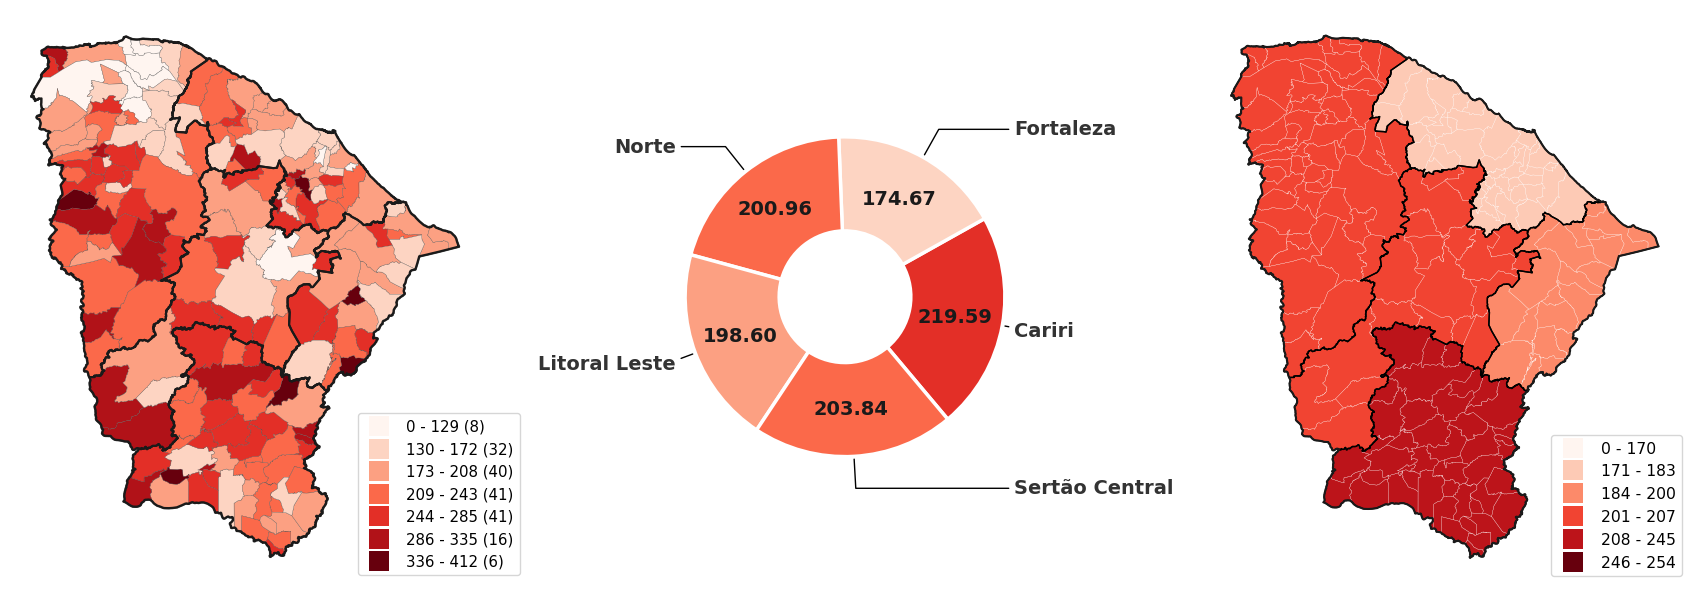

In [38]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2, AX3) = plt.subplots(1,3, figsize=(17,10))
geodata_df_temp.set_geometry("geometry")

macro_df = geodata_df_temp.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_original"]]
macro_df = macro_df.set_geometry("geometry_original")

map_counts = mapclassify.NaturalBreaks(geodata_df_temp[pd.notna(geodata_df_temp[f"txmort_{preffix}_2022"])][f"txmort_{preffix}_2022"], k=7).counts
geodata_df_temp.plot(ax=AX1, zorder=3, column=f'txmort_{preffix}_2022', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.5)


# -- PIE CHART
radius = 0.85
values = val_original
label_macro_name = macro_original_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_original
wedges, texts = AX2.pie(val_original, colors=color_original, labels=[ f'{v:.2f}' for v in val_original ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=14, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=14, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)

macro_original_df.plot(ax=AX3, zorder=3, column="Taxa de Mortalidade", edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': upper_bounds},
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
geodata_df_temp.plot(ax=AX3, zorder=3, column=f'txmort_{preffix}_2022', color='none', edgecolor="#ffffff", linewidth=0.15)
macro_df.plot(ax=AX3, color="none", zorder=3, edgecolor="#000000", linewidth=1.)
ce_df.plot(ax=AX3, color='none', zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

for axis in [AX1, AX2, AX3]:
    axis.axis('off')

for index, axis in enumerate([AX1, AX3]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    if index==0:
        new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 10.8}, bbox_to_anchor=(1.1, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
    else:
        new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 11.2}, bbox_to_anchor=(1.02, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"tx_mort_{preffix}_2022_original_pie_regioes.png"), dpi=250, bbox_inches='tight')

### **Figura: Mosaico Pizza - 8 divisões**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_9772\493347679.py:96: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_temp.plot(ax=AX3, zorder=3, column=f'txmort_{preffix}_2022', color='none', edgecolor="#ffffff", linewidth=0.15)


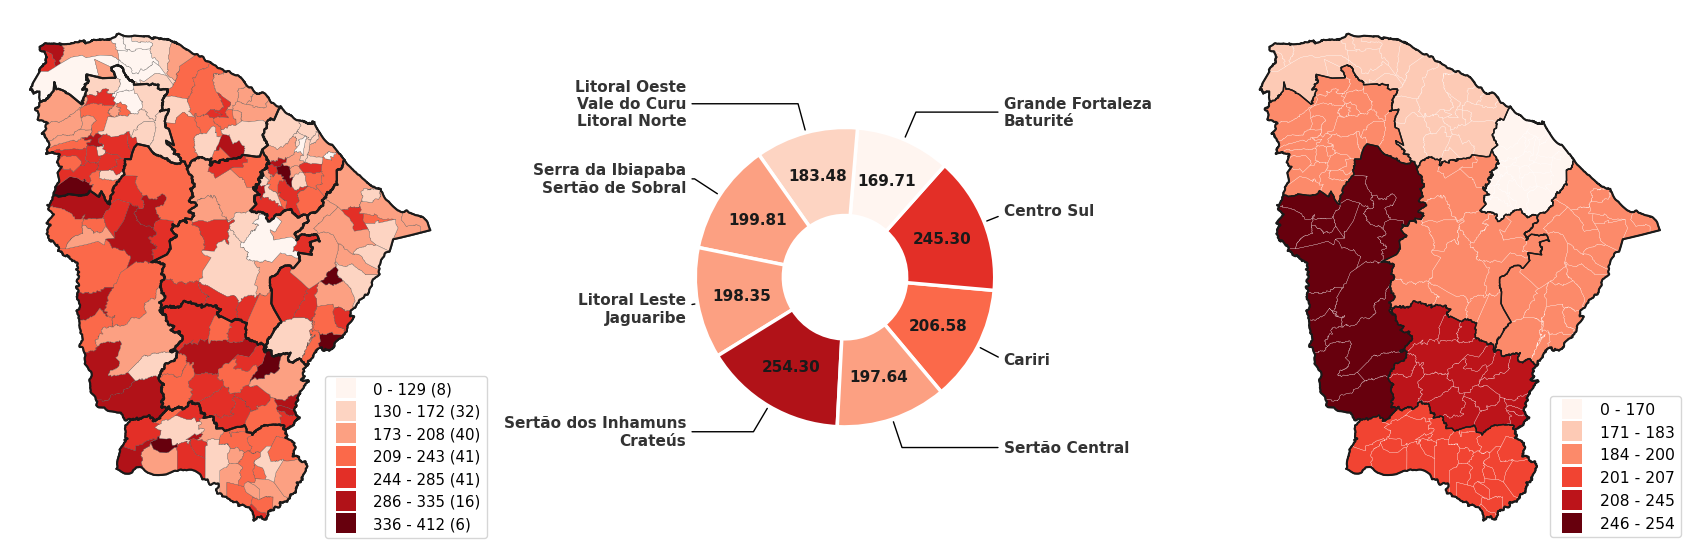

In [39]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2, AX3) = plt.subplots(1,3, figsize=(17,11))
geodata_df_temp.set_geometry("geometry")

macro_df = geodata_df_temp.drop_duplicates("REGIAO_SAUDE_8", keep='first')[["REGIAO_SAUDE_8", "geometry_regiao8"]]
macro_df = macro_df.set_geometry("geometry_regiao8")

map_counts = mapclassify.NaturalBreaks(geodata_df_temp[pd.notna(geodata_df_temp[f"txmort_{preffix}_2022"])][f"txmort_{preffix}_2022"], k=7).counts
geodata_df_temp.plot(ax=AX1, zorder=3, column=f'txmort_{preffix}_2022', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=1.5)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

# -- PIE CHART
radius = 0.85
values = val_proposta
label_macro_name = macro_proposal_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_proposta
wedges, texts = AX2.pie(val_proposta, colors=color_proposta, labels=[ f'{v:.2f}' for v in val_proposta ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=11., va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=11., weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)


macro_proposal_df.plot(ax=AX3, zorder=3, column="Taxa de Mortalidade", edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': upper_bounds},
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
geodata_df_temp.plot(ax=AX3, zorder=3, column=f'txmort_{preffix}_2022', color='none', edgecolor="#ffffff", linewidth=0.15)
ce_df.plot(ax=AX3, color='none', zorder=3, edgecolor="#1a1a1a", linewidth=1.5)
macro_df.plot(ax=AX3, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.)


for axis in [AX1, AX2, AX3]:
    axis.axis('off')

for index, axis in enumerate([AX1, AX3]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    if index==0:
        new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 10.8}, bbox_to_anchor=(1.1, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
    else:
        new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 11.2}, bbox_to_anchor=(1.02, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"tx_mort_{preffix}_2022_proposta8_pie_regioes.png"), dpi=250, bbox_inches='tight')
#fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", "tx_mort_2022_proposta_pie.png"), dpi=250, bbox_inches='tight')

### **Figura: Mosaico Pizza - 10 divisões**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_9772\3990726350.py:96: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_temp.plot(ax=AX3, zorder=3, column=f'txmort_{preffix}_2022', color='none', edgecolor="#ffffff", linewidth=0.15)


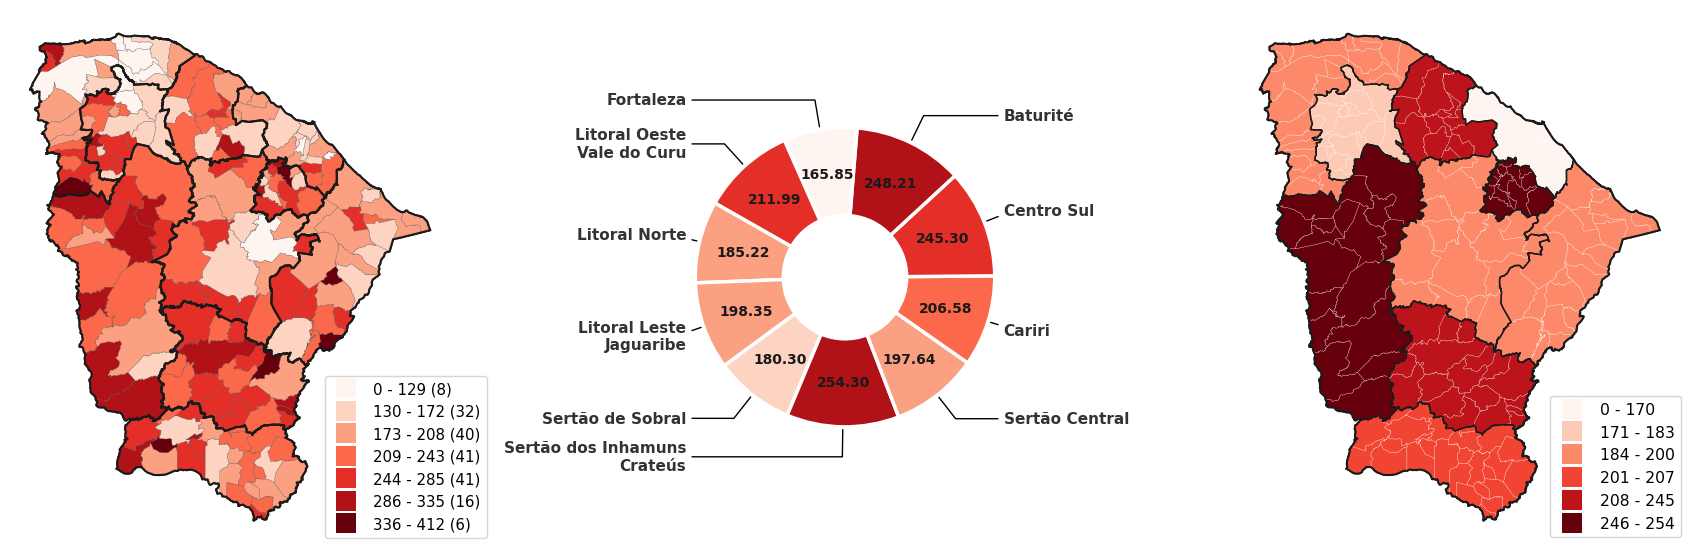

In [40]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2, AX3) = plt.subplots(1,3, figsize=(17,11))
geodata_df_temp.set_geometry("geometry")

macro_df = geodata_df_temp.drop_duplicates("REGIAO_SAUDE_10", keep='first')[["REGIAO_SAUDE_10", "geometry_regiao10"]]
macro_df = macro_df.set_geometry("geometry_regiao10")

map_counts = mapclassify.NaturalBreaks(geodata_df_temp[pd.notna(geodata_df_temp[f"txmort_{preffix}_2022"])][f"txmort_{preffix}_2022"], k=7).counts
geodata_df_temp.plot(ax=AX1, zorder=3, column=f'txmort_{preffix}_2022', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=1.5)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

# -- PIE CHART
radius = 0.85
values = val_proposta10
label_macro_name = macro_proposal10_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_proposta10
wedges, texts = AX2.pie(val_proposta10, colors=color_proposta10, labels=[ f'{v:.2f}' for v in val_proposta10 ], labeldistance=.7, startangle=-35, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=10., va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=11., weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)


macro_proposal10_df.plot(ax=AX3, zorder=3, column="Taxa de Mortalidade", edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': upper_bounds},
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
geodata_df_temp.plot(ax=AX3, zorder=3, column=f'txmort_{preffix}_2022', color='none', edgecolor="#ffffff", linewidth=0.15)
ce_df.plot(ax=AX3, color='none', zorder=3, edgecolor="#1a1a1a", linewidth=1.5)
macro_df.plot(ax=AX3, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.)


for axis in [AX1, AX2, AX3]:
    axis.axis('off')

for index, axis in enumerate([AX1, AX3]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    if index==0:
        new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 10.8}, bbox_to_anchor=(1.1, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
    else:
        new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 11.2}, bbox_to_anchor=(1.02, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"tx_mort_{preffix}_2022_proposta10_pie_regioes.png"), dpi=250, bbox_inches='tight')
#fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", "tx_mort_2022_proposta_pie.png"), dpi=250, bbox_inches='tight')

### **Mortalidade Infantil**

In [41]:
sinasc_df = pd.read_parquet(basepath.joinpath("sinasc", "PARQUET", "DN2023.parquet"))

In [42]:
sim_df1 = sim_df.copy()
sim_df1["DTOBITO"] = pd.to_datetime(sim_df1["DTOBITO"].apply(lambda x: f"{x[:2]}/{x[2:4]}/{x[4:]}"), format="%d/%m/%Y", errors="coerce")
sim_df1["DTNASC"] = pd.to_datetime(sim_df1["DTNASC"].apply(lambda x: f"{x[:2]}/{x[2:4]}/{x[4:]}" if pd.notna(x) else np.nan), format="%d/%m/%Y", errors="coerce")

# -- to filter 
sim_df1["ANO_NASCIMENTO"] = sim_df1["DTNASC"].apply(lambda x: x.year if pd.notna(x) else np.nan)
sim_df1["ANO_OBITO"] = sim_df1["DTOBITO"].apply(lambda x: x.year if pd.notna(x) else np.nan)

sim_df1 = sim_df1[sim_df1["ANO_OBITO"]==2023]
sim_df1["CAUSABAS3"] = sim_df1["CAUSABAS"].apply(lambda x: x[:3] if pd.notna(x) else np.nan)
subcat["CAUSABAS3"] = subcat["SUBCAT"].apply(lambda x: x[:3])

In [43]:
sim_df1["IDADE_FMT"] = sim_df1["IDADE"].apply(lambda x: int(x[1:]) if pd.notna(x) and x[0]=='4' else ( 100+int(x[:1]) if pd.notna(x) and x[0]=='5' else ( 0 if pd.notna(x) and x!='999' else np.nan ) ) )

In [44]:
sim_infantil = sim_df1[sim_df1["IDADE_FMT"]<1]
sim_infantil.shape

(1259, 143)

### **Mosaico Tx infantil**

In [62]:
ce_df = gpd.read_file(geopath.joinpath("shape_ce", "CE_UF_2022.shp"))
preffix = "infantil"

nv_2023 = sinasc_df["CODMUNRES"].value_counts().reset_index().rename({"count": "NV_2023", "CODMUNRES": "GEOCOD6"}, axis=1)
geodata_df_infantil = ce_geodata_df.merge(nv_2023, how="left")
geodata_df_infantil.head(2)

ano = 2023
col_mun_name = "CODMUNRES"
counting_all = sim_df1[col_mun_name].value_counts().reset_index().rename({col_mun_name: "GEOCOD6"}, axis=1)
counting_inf = sim_infantil[col_mun_name].value_counts().reset_index().rename({col_mun_name: "GEOCOD6"}, axis=1)
counting_all["GEOCOD6"] = counting_all["GEOCOD6"].astype(str)
counting_inf["GEOCOD6"] = counting_inf["GEOCOD6"].astype(str)
#
geodata_df_infantil = geodata_df_infantil.merge(counting_all, on="GEOCOD6", how='left').rename({'count': f'count_all_2023'}, axis=1)
geodata_df_infantil = geodata_df_infantil.merge(counting_inf, on="GEOCOD6", how='left').rename({'count': f'count_inf_2023'}, axis=1)
geodata_df_infantil[f'txmort_inf_2023'] = (geodata_df_infantil[f'count_inf_2023']/geodata_df_infantil[f'NV_2023'])*1000

In [63]:
aux = geodata_df_infantil.drop_duplicates(subset=["NOME_REGIAO_ORIGINAL"])[["MACRO_ID", "NOME_REGIAO_ORIGINAL"]]
aux8 = geodata_df_infantil.drop_duplicates(subset=["NOME_REGIAO_SAUDE_8"])[["REGIAO_SAUDE_8", "NOME_REGIAO_SAUDE_8"]]
aux10 = geodata_df_infantil.drop_duplicates(subset=["NOME_REGIAO_SAUDE_10"])[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10"]]
aux = dict(zip(aux["MACRO_ID"], aux["NOME_REGIAO_ORIGINAL"]))
aux8 = dict(zip(aux8["REGIAO_SAUDE_8"], aux8["NOME_REGIAO_SAUDE_8"]))
aux10 = dict(zip(aux10["REGIAO_SAUDE_10"], aux10["NOME_REGIAO_SAUDE_10"]))


pop_macro_original = geodata_df_infantil.groupby("MACRO_ID")["NV_2023"].sum().reset_index()
obito_total_macro_original = geodata_df_infantil.groupby("MACRO_ID")[f"count_inf_2023"].sum().reset_index()
qt_muni_original = geodata_df_infantil.groupby("MACRO_ID")["NM_MUN"].count().reset_index()
original_df = pop_macro_original.merge(qt_muni_original).merge(obito_total_macro_original)
original_df["Taxa de Mortalidade"] = (original_df[f'count_inf_2023']/original_df['NV_2023'])*1000
original_df["Macrorregião de Saúde"] = original_df["MACRO_ID"].map(aux)
original_df = original_df.rename({f'count_inf_2023': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#original_df = original_df[["Macrorregião de Saúde"]+list(original_df.columns[2:-1])]

# -- proposal 8
pop_macro_proposal = geodata_df_infantil.groupby("REGIAO_SAUDE_8")["NV_2023"].sum().reset_index()
obito_total_macro_proposal = geodata_df_infantil.groupby("REGIAO_SAUDE_8")[f"count_inf_2023"].sum().reset_index()
qt_muni_proposal = geodata_df_infantil.groupby("REGIAO_SAUDE_8")["NM_MUN"].count().reset_index()
proposal_df = pop_macro_proposal.merge(qt_muni_proposal).merge(obito_total_macro_proposal)
proposal_df["Taxa de Mortalidade"] = (proposal_df[f'count_inf_2023']/proposal_df['NV_2023'])*1000
proposal_df["Macrorregião de Saúde"] = proposal_df["REGIAO_SAUDE_8"].map(name_macro)
proposal_df = proposal_df.rename({f'count_inf_2023': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#proposal_df = proposal_df[["Macrorregião de Saúde"]+list(proposal_df.columns[:])]

# -- proposal 10
pop_macro_proposal10 = geodata_df_infantil.groupby("REGIAO_SAUDE_10")["NV_2023"].sum().reset_index()
obito_total_macro_proposal10 = geodata_df_infantil.groupby("REGIAO_SAUDE_10")[f"count_inf_2023"].sum().reset_index()
qt_muni_proposal10 = geodata_df_infantil.groupby("REGIAO_SAUDE_10")["NM_MUN"].count().reset_index()
proposal10_df = pop_macro_proposal10.merge(qt_muni_proposal10).merge(obito_total_macro_proposal10)
proposal10_df["Taxa de Mortalidade"] = (proposal10_df[f'count_inf_2023']/proposal10_df['NV_2023'])*1000
proposal10_df["Macrorregião de Saúde"] = proposal10_df["REGIAO_SAUDE_10"].map(aux10)
proposal10_df = proposal10_df.rename({f'count_inf_2023': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#proposal_df = proposal_df[["Macrorregião de Saúde"]+list(proposal_df.columns[:])]

macro_original_df = geodata_df_infantil.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_original"]]
macro_original_df = macro_original_df.set_geometry("geometry_original")
macro_original_df = macro_original_df.merge(original_df)

macro_proposal_df = geodata_df_infantil.drop_duplicates("REGIAO_SAUDE_8", keep='first')[["REGIAO_SAUDE_8", "geometry_regiao8"]]#.merge(new_macro_geometry).drop("geometry_macro", axis=1)
macro_proposal_df = macro_proposal_df.set_geometry("geometry_regiao8")
macro_proposal_df = macro_proposal_df.merge(proposal_df)

macro_proposal10_df = geodata_df_infantil.drop_duplicates("REGIAO_SAUDE_10", keep='first')[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10", "geometry_regiao10"]]#.merge(new_macro_geometry).drop("geometry_macro", axis=1)
macro_proposal10_df = macro_proposal10_df.set_geometry("geometry_regiao10")
macro_proposal10_df = macro_proposal10_df.merge(proposal10_df)

In [64]:
# -- define the colors for the pie plot (according)
k_macro = 5
macro_proposal_nb = mapclassify.NaturalBreaks(macro_proposal_df["Taxa de Mortalidade"], k=k_macro)
map_counts_proposal = macro_proposal_nb.counts
upper_bounds = macro_proposal_nb.bins

map_original_nb = mapclassify.UserDefined(macro_original_df["Taxa de Mortalidade"], upper_bounds)
map_counts_original = map_original_nb.counts

map_proposal10_nb = mapclassify.UserDefined(macro_proposal10_df["Taxa de Mortalidade"], upper_bounds)
map_counts_proposal10 = map_proposal10_nb.counts

val_original = macro_original_df["Taxa de Mortalidade"].values
val_proposta = macro_proposal_df["Taxa de Mortalidade"].values
val_proposta10 = macro_proposal10_df["Taxa de Mortalidade"].values

pos_original = [ upper_bounds[value>upper_bounds].shape[0] for value in val_original ]
pos_proposta = [ upper_bounds[value>upper_bounds].shape[0] for value in val_proposta ]
pos_proposta10 = [ upper_bounds[value>upper_bounds].shape[0] for value in val_proposta10 ]

cmap_reds = matplotlib.colormaps.get_cmap("Reds")
arr = cmap_reds(1.*np.arange(k_macro)/k_macro)

color_original = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_original ]
color_proposta = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_proposta ]
color_proposta10 = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_proposta10 ]

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


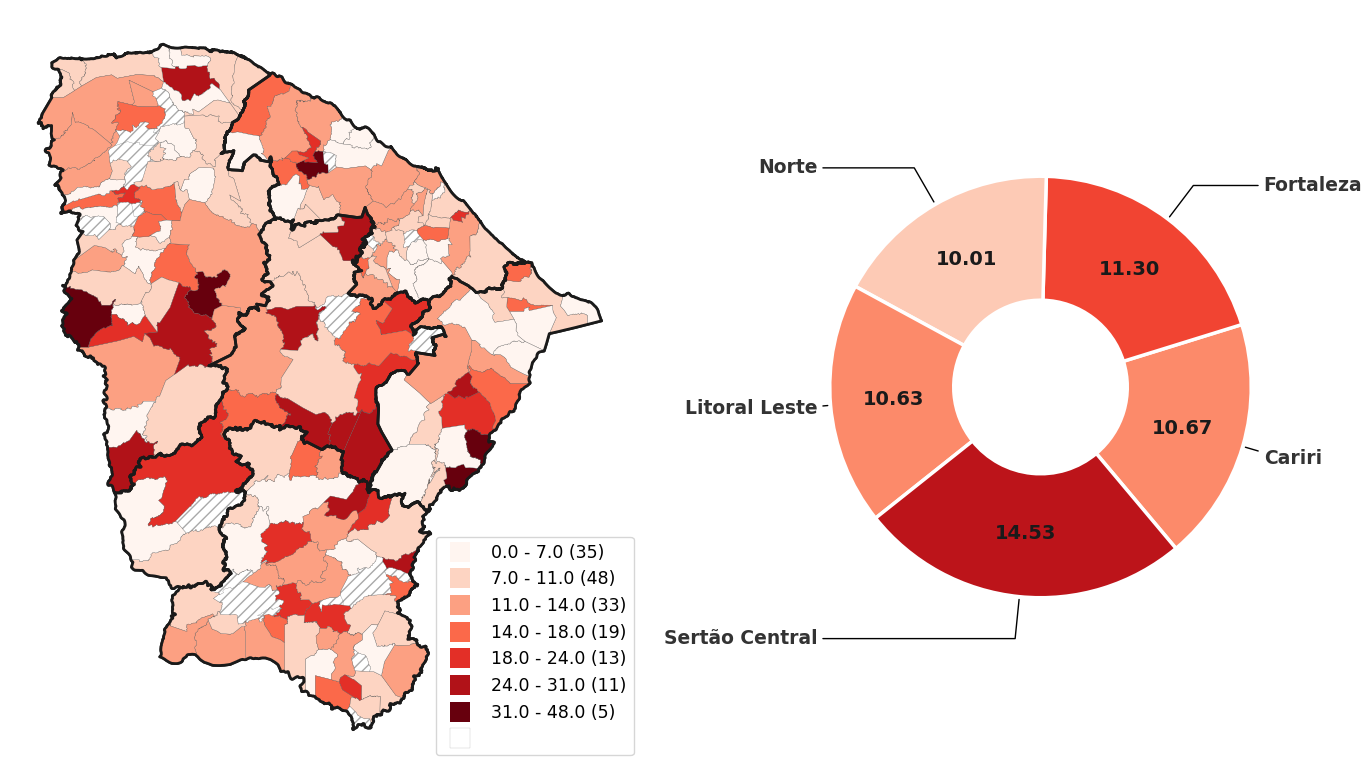

In [51]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.1f} - {label[1]:,.1f}'.replace(",",".")
    else:
        return f'{label[0]:,.1f} - {label[1]:,.1f} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2) = plt.subplots(1,2, figsize=(14,8))
geodata_df_infantil.set_geometry("geometry")

macro_df = geodata_df_infantil.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "geometry_original"]]
macro_df = macro_df.set_geometry("geometry_original")

map_counts = mapclassify.NaturalBreaks(geodata_df_infantil[pd.notna(geodata_df_infantil[f"txmort_inf_2023"])][f"txmort_inf_2023"], k=7).counts
geodata_df_infantil.plot(ax=AX1, zorder=3, column=f'txmort_inf_2023', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=2.0)


# -- PIE CHART
radius = 0.85
values = val_original
label_macro_name = macro_original_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_original
wedges, texts = AX2.pie(val_original, colors=color_original, labels=[ f'{v:.2f}' for v in val_original ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=14, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=13.5, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)


for axis in [AX1, AX2]:
    axis.axis('off')

for index, axis in enumerate([AX1]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 12.5}, bbox_to_anchor=(1.02, 0.0), loc=4, title="",  title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", "tx_mort_infantil_2023_original_pie.png"), dpi=250, bbox_inches='tight')

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


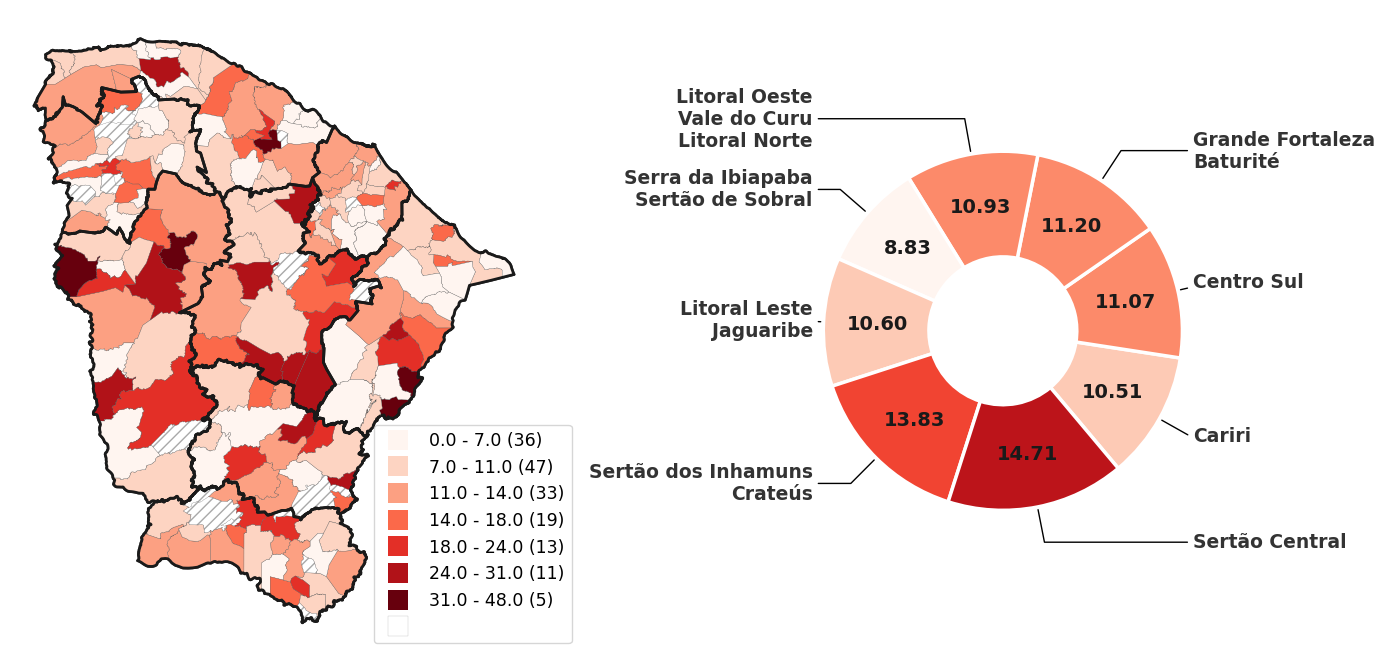

In [54]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.1f} - {label[1]:,.1f}'.replace(",",".")
    else:
        return f'{label[0]:,.1f} - {label[1]:,.1f} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2) = plt.subplots(1,2, figsize=(14,8))
geodata_df_infantil.set_geometry("geometry")

macro_df = geodata_df_infantil.drop_duplicates("REGIAO_SAUDE_8", keep='first')[["REGIAO_SAUDE_8", "geometry_regiao8"]]
macro_df = macro_df.set_geometry("geometry_regiao8")

map_counts = mapclassify.NaturalBreaks(geodata_df_infantil[pd.notna(geodata_df_infantil[f"txmort_inf_2023"])][f"txmort_inf_2023"], k=7).counts
geodata_df_infantil.plot(ax=AX1, zorder=3, column=f'txmort_inf_2023', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=2.0)


# -- PIE CHART
radius = 0.85
values = val_proposta
label_macro_name = macro_proposal_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_proposta
wedges, texts = AX2.pie(val_proposta, colors=color_proposta, labels=[ f'{v:.2f}' for v in val_proposta ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=14, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=13.5, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)


for axis in [AX1, AX2]:
    axis.axis('off')

for index, axis in enumerate([AX1]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 12.5}, bbox_to_anchor=(1.08, 0.0), loc=4, title="",  title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", "tx_mort_infantil_2023_proposta8_pie.png"), dpi=250, bbox_inches='tight')

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


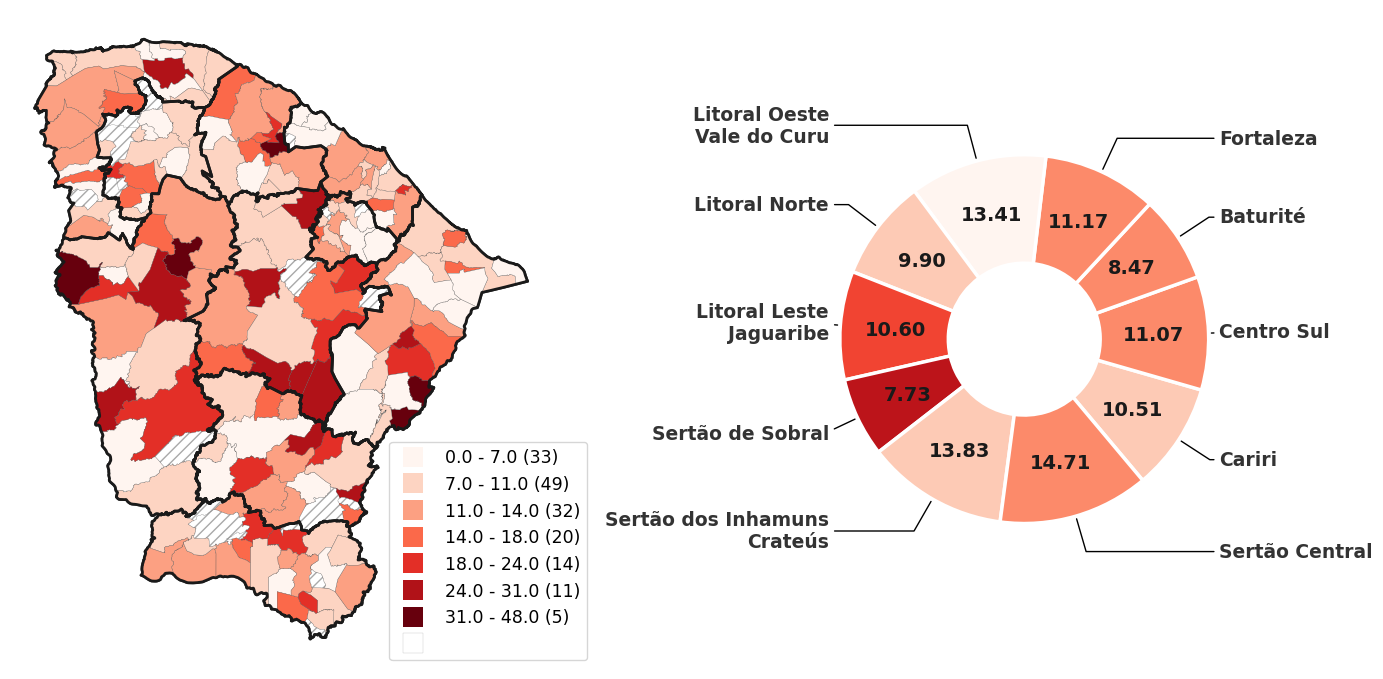

In [66]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.1f} - {label[1]:,.1f}'.replace(",",".")
    else:
        return f'{label[0]:,.1f} - {label[1]:,.1f} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2) = plt.subplots(1,2, figsize=(14,8))
geodata_df_infantil.set_geometry("geometry")

macro_df = geodata_df_infantil.drop_duplicates("REGIAO_SAUDE_10", keep='first')[["REGIAO_SAUDE_10", "geometry_regiao10"]]
macro_df = macro_df.set_geometry("geometry_regiao10")

map_counts = mapclassify.NaturalBreaks(geodata_df_infantil[pd.notna(geodata_df_infantil[f"txmort_inf_2023"])][f"txmort_inf_2023"], k=7).counts
geodata_df_infantil.plot(ax=AX1, zorder=3, column=f'txmort_inf_2023', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=2.0)


# -- PIE CHART
radius = 0.85
values = val_proposta10
label_macro_name = macro_proposal10_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_proposta10
wedges, texts = AX2.pie(val_proposta10, colors=color_proposta, labels=[ f'{v:.2f}' for v in val_proposta10 ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=14, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=13.5, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)


for axis in [AX1, AX2]:
    axis.axis('off')

for index, axis in enumerate([AX1]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 12.5}, bbox_to_anchor=(1.08, 0.0), loc=4, title="",  title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", "tx_mort_infantil_2023_proposta10_pie.png"), dpi=250, bbox_inches='tight')

## **Leitos**

In [92]:
leitos_muni_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "leitos_hospitais_por_municipio_1801_2306.parquet"))
geodata_df_hosp = ce_geodata_df.merge(leitos_muni_df, on="GEOCOD6", how="left")
geodata_df_hosp["Leitos por 100.000 hab"] = (geodata_df_hosp["NUMLEITOS"]/geodata_df_hosp["2022"])*100000

In [93]:
aux = geodata_df_hosp.drop_duplicates(subset=["NOME_REGIAO_ORIGINAL"])[["MACRO_ID", "NOME_REGIAO_ORIGINAL"]]
aux8 = geodata_df_hosp.drop_duplicates(subset=["NOME_REGIAO_SAUDE_8"])[["REGIAO_SAUDE_8", "NOME_REGIAO_SAUDE_8"]]
aux10 = geodata_df_hosp.drop_duplicates(subset=["NOME_REGIAO_SAUDE_10"])[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10"]]
aux = dict(zip(aux["MACRO_ID"], aux["NOME_REGIAO_ORIGINAL"]))
aux8 = dict(zip(aux8["REGIAO_SAUDE_8"], aux8["NOME_REGIAO_SAUDE_8"]))
aux10 = dict(zip(aux10["REGIAO_SAUDE_10"], aux10["NOME_REGIAO_SAUDE_10"]))


pop_macro_original = geodata_df_hosp.groupby("MACRO_ID")["2022"].sum().reset_index()
obito_total_macro_original = geodata_df_hosp.groupby("MACRO_ID")[f"NUMLEITOS"].sum().reset_index()
qt_muni_original = geodata_df_hosp.groupby("MACRO_ID")["NM_MUN"].count().reset_index()
original_df = pop_macro_original.merge(qt_muni_original).merge(obito_total_macro_original)
original_df["Taxa de Mortalidade"] = (original_df[f'NUMLEITOS']/original_df['2022'])*100000
original_df["Macrorregião de Saúde"] = original_df["MACRO_ID"].map(aux)
original_df = original_df.rename({f'NUMLEITOS': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#original_df = original_df[["Macrorregião de Saúde"]+list(original_df.columns[2:-1])]

# -- proposal 8
pop_macro_proposal = geodata_df_hosp.groupby("REGIAO_SAUDE_8")["2022"].sum().reset_index()
obito_total_macro_proposal = geodata_df_hosp.groupby("REGIAO_SAUDE_8")[f"NUMLEITOS"].sum().reset_index()
qt_muni_proposal = geodata_df_hosp.groupby("REGIAO_SAUDE_8")["NM_MUN"].count().reset_index()
proposal_df = pop_macro_proposal.merge(qt_muni_proposal).merge(obito_total_macro_proposal)
proposal_df["Taxa de Mortalidade"] = (proposal_df[f'NUMLEITOS']/proposal_df['2022'])*100000
proposal_df["Macrorregião de Saúde"] = proposal_df["REGIAO_SAUDE_8"].map(name_macro)
proposal_df = proposal_df.rename({f'NUMLEITOS': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#proposal_df = proposal_df[["Macrorregião de Saúde"]+list(proposal_df.columns[:])]

# -- proposal 10
pop_macro_proposal10 = geodata_df_hosp.groupby("REGIAO_SAUDE_10")["2022"].sum().reset_index()
obito_total_macro_proposal10 = geodata_df_hosp.groupby("REGIAO_SAUDE_10")[f"NUMLEITOS"].sum().reset_index()
qt_muni_proposal10 = geodata_df_hosp.groupby("REGIAO_SAUDE_10")["NM_MUN"].count().reset_index()
proposal10_df = pop_macro_proposal10.merge(qt_muni_proposal10).merge(obito_total_macro_proposal10)
proposal10_df["Taxa de Mortalidade"] = (proposal10_df[f'NUMLEITOS']/proposal10_df['2022'])*100000
proposal10_df["Macrorregião de Saúde"] = proposal10_df["REGIAO_SAUDE_10"].map(aux10)
proposal10_df = proposal10_df.rename({f'NUMLEITOS': "Óbitos totais", "NM_MUN": "Qt. Municípios"}, axis=1)
#proposal_df = proposal_df[["Macrorregião de Saúde"]+list(proposal_df.columns[:])]

macro_original_df = geodata_df_hosp.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_original"]]
macro_original_df = macro_original_df.set_geometry("geometry_original")
macro_original_df = macro_original_df.merge(original_df)

macro_proposal_df = geodata_df_hosp.drop_duplicates("REGIAO_SAUDE_8", keep='first')[["REGIAO_SAUDE_8", "geometry_regiao8"]]#.merge(new_macro_geometry).drop("geometry_macro", axis=1)
macro_proposal_df = macro_proposal_df.set_geometry("geometry_regiao8")
macro_proposal_df = macro_proposal_df.merge(proposal_df)

macro_proposal10_df = geodata_df_hosp.drop_duplicates("REGIAO_SAUDE_10", keep='first')[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10", "geometry_regiao10"]]#.merge(new_macro_geometry).drop("geometry_macro", axis=1)
macro_proposal10_df = macro_proposal10_df.set_geometry("geometry_regiao10")
macro_proposal10_df = macro_proposal10_df.merge(proposal10_df)

In [94]:
# -- define the colors for the pie plot (according)
k_macro = 7
macro_proposal10_nb = mapclassify.NaturalBreaks(macro_proposal10_df["Taxa de Mortalidade"], k=k_macro)
map_counts_proposal10 = macro_proposal10_nb.counts
upper_bounds = macro_proposal10_nb.bins

map_original_nb = mapclassify.UserDefined(macro_original_df["Taxa de Mortalidade"], upper_bounds)
map_counts_original = map_original_nb.counts

map_proposal_nb = mapclassify.UserDefined(macro_proposal_df["Taxa de Mortalidade"], upper_bounds)
map_counts_proposal = map_proposal_nb.counts

val_original = macro_original_df["Taxa de Mortalidade"].values
val_proposta = macro_proposal_df["Taxa de Mortalidade"].values
val_proposta10 = macro_proposal10_df["Taxa de Mortalidade"].values

pos_original = [ upper_bounds[value>upper_bounds].shape[0] for value in val_original ]
pos_proposta = [ upper_bounds[value>upper_bounds].shape[0] for value in val_proposta ]
pos_proposta10 = [ upper_bounds[value>upper_bounds].shape[0] for value in val_proposta10 ]

cmap_reds = matplotlib.colormaps.get_cmap("Reds")
arr = cmap_reds(1.*np.arange(k_macro)/k_macro)

color_original = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_original ]
color_proposta = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_proposta ]
color_proposta10 = [ matplotlib.colors.rgb2hex(tuple(arr[index])) for index in pos_proposta10 ]

print(arr.shape, k_macro)

(7, 4) 7


c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### **Original**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_9772\546702834.py:96: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_temp.plot(ax=AX3, zorder=3, column=f'Leitos por 100.000 hab', color='none', edgecolor="#ffffff", linewidth=0.15)


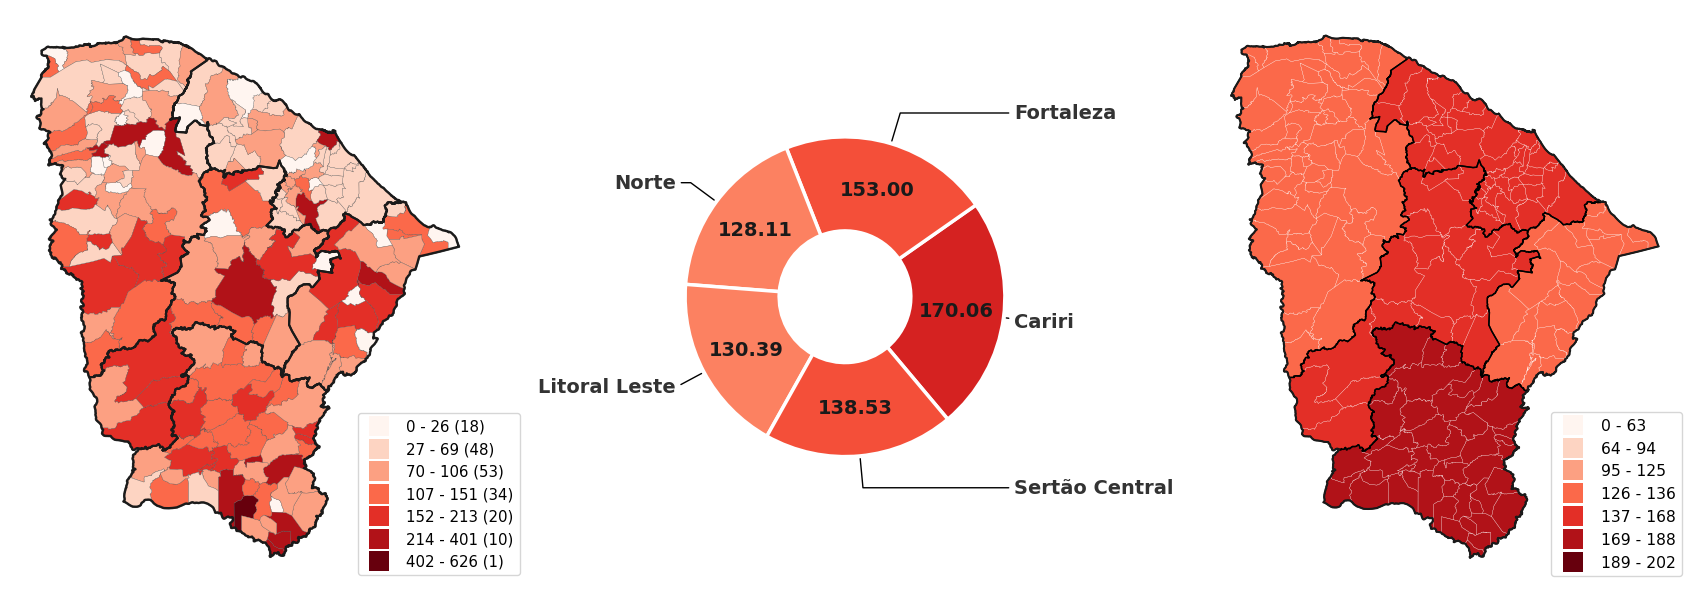

In [95]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2, AX3) = plt.subplots(1,3, figsize=(17,10))
geodata_df_hosp.set_geometry("geometry")

macro_df = geodata_df_hosp.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_original"]]
macro_df = macro_df.set_geometry("geometry_original")

map_counts = mapclassify.NaturalBreaks(geodata_df_hosp[pd.notna(geodata_df_hosp[f"Leitos por 100.000 hab"])][f"Leitos por 100.000 hab"], k=7).counts
geodata_df_hosp.plot(ax=AX1, zorder=3, column=f"Leitos por 100.000 hab", edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.5)


# -- PIE CHART
radius = 0.85
values = val_original
label_macro_name = macro_original_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_original
wedges, texts = AX2.pie(val_original, colors=color_original, labels=[ f'{v:.2f}' for v in val_original ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=14, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=14, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)

macro_original_df.plot(ax=AX3, zorder=3, column="Taxa de Mortalidade", edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': upper_bounds},
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
geodata_df_temp.plot(ax=AX3, zorder=3, column=f'Leitos por 100.000 hab', color='none', edgecolor="#ffffff", linewidth=0.15)
macro_df.plot(ax=AX3, color="none", zorder=3, edgecolor="#000000", linewidth=1.)
ce_df.plot(ax=AX3, color='none', zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

for axis in [AX1, AX2, AX3]:
    axis.axis('off')

for index, axis in enumerate([AX1, AX3]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    if index==0:
        new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 10.8}, bbox_to_anchor=(1.1, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
    else:
        new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 11.2}, bbox_to_anchor=(1.02, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"leitos_100mil_2022_original_pie_regioes.png"), dpi=250, bbox_inches='tight')

### **8 Regiões**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_9772\2396566773.py:95: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_temp.plot(ax=AX3, zorder=3, column=f'Leitos por 100.000 hab', color='none', edgecolor="#ffffff", linewidth=0.15)


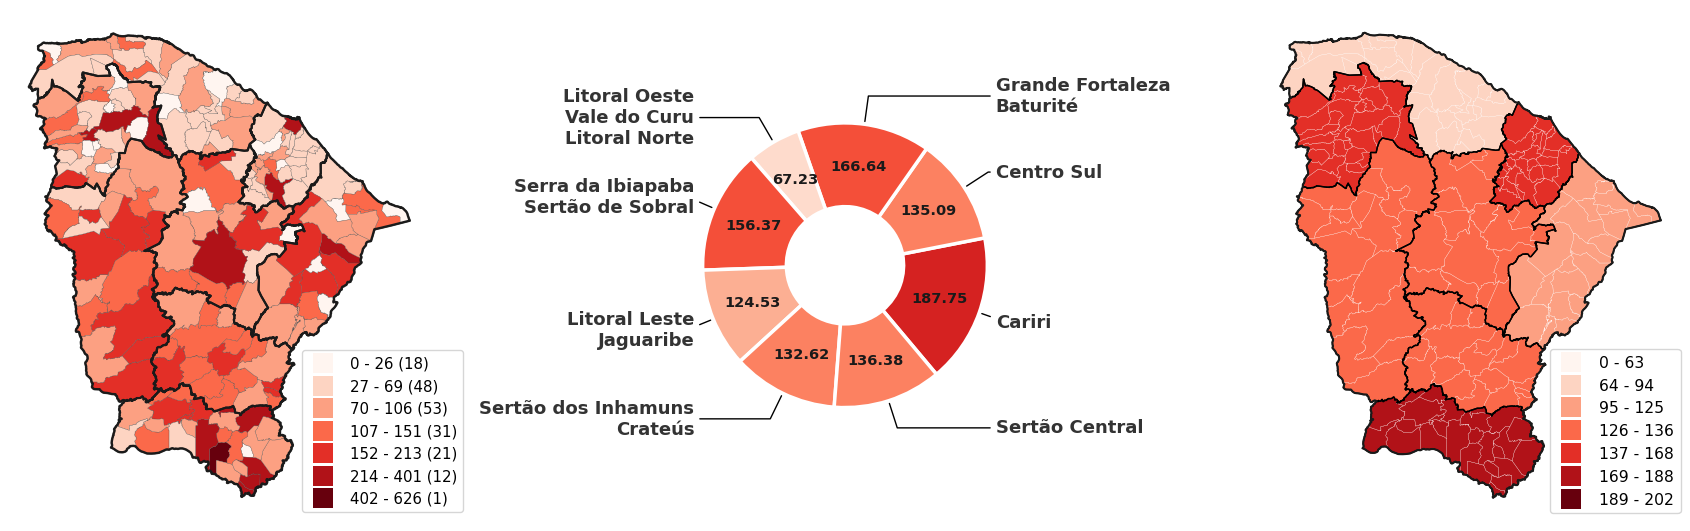

In [96]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2, AX3) = plt.subplots(1,3, figsize=(17,10))
geodata_df_hosp.set_geometry("geometry")

macro_df = geodata_df_hosp.drop_duplicates("REGIAO_SAUDE_8", keep='first')[["REGIAO_SAUDE_8", "MACRO_NOME", "geometry_regiao8"]]
macro_df = macro_df.set_geometry("geometry_regiao8")

map_counts = mapclassify.NaturalBreaks(geodata_df_hosp[pd.notna(geodata_df_hosp[f"Leitos por 100.000 hab"])][f"Leitos por 100.000 hab"], k=7).counts
geodata_df_hosp.plot(ax=AX1, zorder=3, column=f"Leitos por 100.000 hab", edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

# -- PIE CHART
radius = 0.85
values = val_proposta
label_macro_name = macro_proposal_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_proposta
wedges, texts = AX2.pie(val_proposta, colors=color_proposta, labels=[ f'{v:.2f}' for v in val_proposta ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=10.5, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=13, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)

macro_proposal_df.plot(ax=AX3, zorder=3, column="Taxa de Mortalidade", edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': upper_bounds},
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
geodata_df_temp.plot(ax=AX3, zorder=3, column=f'Leitos por 100.000 hab', color='none', edgecolor="#ffffff", linewidth=0.15)
macro_df.plot(ax=AX3, color="none", zorder=3, edgecolor="#000000", linewidth=1.)
ce_df.plot(ax=AX3, color='none', zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

for axis in [AX1, AX2, AX3]:
    axis.axis('off')

for index, axis in enumerate([AX1, AX3]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    if index==0:
        new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 10.8}, bbox_to_anchor=(1.1, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
    else:
        new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 11.2}, bbox_to_anchor=(1.02, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"leitos_100mil_2022_proposta8_pie_regioes.png"), dpi=250, bbox_inches='tight')

### **10 regiões**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_9772\511794005.py:95: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_temp.plot(ax=AX3, zorder=3, column=f'Leitos por 100.000 hab', color='none', edgecolor="#ffffff", linewidth=0.15)


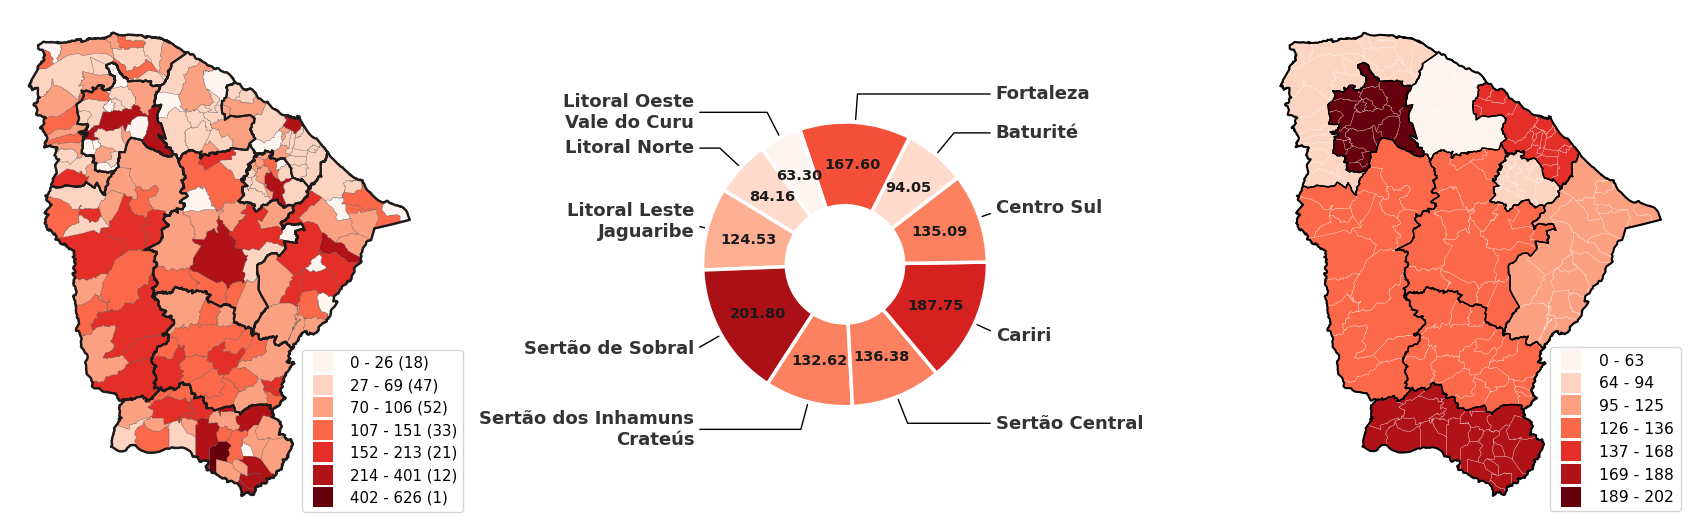

In [97]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, (AX1, AX2, AX3) = plt.subplots(1,3, figsize=(17,10))
geodata_df_hosp.set_geometry("geometry")

macro_df = geodata_df_hosp.drop_duplicates("REGIAO_SAUDE_10", keep='first')[["REGIAO_SAUDE_8", "MACRO_NOME", "geometry_regiao10"]]
macro_df = macro_df.set_geometry("geometry_regiao10")

map_counts = mapclassify.NaturalBreaks(geodata_df_hosp[pd.notna(geodata_df_hosp[f"Leitos por 100.000 hab"])][f"Leitos por 100.000 hab"], k=7).counts
geodata_df_hosp.plot(ax=AX1, zorder=3, column=f"Leitos por 100.000 hab", edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.5)

# -- PIE CHART
radius = 0.85
values = val_proposta10
label_macro_name = macro_proposal10_df["Macrorregião de Saúde"].tolist()
label_pop_abs = val_proposta10
wedges, texts = AX2.pie(val_proposta10, colors=color_proposta10, labels=[ f'{v:.2f}' for v in val_proposta10 ], labeldistance=.7, startangle=-50, radius=radius,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='#1a1a1a', weight='bold', fontsize=10.5, va='center', ha='center'))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}".replace(".",","), xy=(x, y), fontsize=13, weight='bold', xytext=(0.9*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)

macro_proposal10_df.plot(ax=AX3, zorder=3, column="Taxa de Mortalidade", edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': upper_bounds},
             cmap="Reds",
             linewidth=0.2,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
geodata_df_temp.plot(ax=AX3, zorder=3, column=f'Leitos por 100.000 hab', color='none', edgecolor="#ffffff", linewidth=0.15)
ce_df.plot(ax=AX3, color='none', zorder=3, edgecolor="#1a1a1a", linewidth=1.5)
macro_df.plot(ax=AX3, color="none", zorder=3, edgecolor="#000000", linewidth=1.)

for axis in [AX1, AX2, AX3]:
    axis.axis('off')

for index, axis in enumerate([AX1, AX3]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    if index==0:
        new_labels =  [ transf_label(index, label, counts=map_counts) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 10.8}, bbox_to_anchor=(1.1, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
    else:
        new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
        axis.legend(lines, new_labels, prop={'size': 11.2}, bbox_to_anchor=(1.02, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"leitos_100mil_2022_proposta10_pie_regioes.png"), dpi=250, bbox_inches='tight')